In [70]:
import gmsh
import numpy as np

In [71]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [72]:
def extract_first_88_nodes(gmsh_file):
    with open(gmsh_file, 'r') as file:
        lines = file.readlines()

    nodes_start = None
    node_coordinates = []

    # Find the $Nodes section and extract the first 88 nodes
    for i, line in enumerate(lines):
        if line.strip() == "$Nodes":
            nodes_start = i + 2  # Skip the $Nodes and the number of nodes line
            break
    
    if nodes_start is not None:
        for i in range(88):
            node_data = lines[nodes_start + i].strip().split()
            node_coordinates.append([float(node_data[1]), float(node_data[2])])
    
    return node_coordinates

def plot_nodes(node_coordinates):
    # Load the image
    img = mpimg.imread('IITM_map_without_background.png')
    img_height, img_width = img.shape[:2]  # Get image dimensions
    
    # Extract x and y coordinates from the nodes
    x_coords, y_coords = zip(*node_coordinates)
    
    plt.figure(figsize=(img_width/100, img_height/100))  # Adjust figure size to match image size in inches
    
    # Plot the image at its original size
    plt.imshow(img, extent=[0, img_width, 0, img_height], alpha = 0.5)
    # plt.figure(figsize=(6, 6))
    plt.plot(x_coords, y_coords, 'ro-', label="Boundary Nodes")
    plt.plot(559,529, 'bo', markersize = 10, label = "Centroid")
    plt.plot(472, 486.7, 'go', markersize=10, label="Gajendra Circle")  # Green 'go' marker for Gajendra Circle
    plt.xlabel("X Coordinates")
    plt.ylabel("Y Coordinates")
    plt.title("Boundary Plot")
    plt.legend()
    plt.grid(True)
    plt.show()



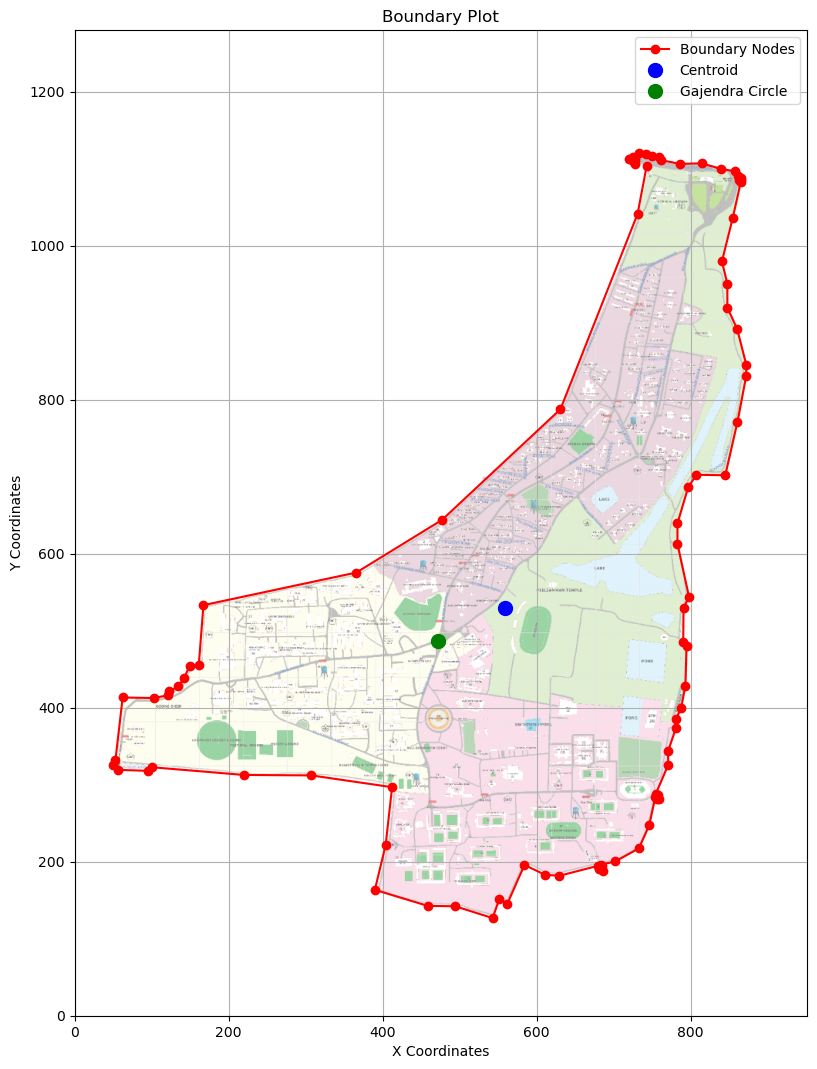

In [73]:
# Replace 'IITM_Map' with the actual name of your gmsh file
gmsh_file = 'IITM_Map_final'
nodes = extract_first_88_nodes(gmsh_file)
plot_nodes(nodes)

In [74]:
def triangle_jacobian(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    
    jacobian = dx_deps*dy_deta - dx_deta*dy_deps
    return jacobian

In [75]:
def numerical_intergation(func,x1,y1,x2,y2,x3,y3):
    pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
    weights = [1/6, 1/6, 1/6]
    
    integral = 0
    
    for i in range(len(weights)):
        integral+= func(pts[i][0],pts[i][1],x1,y1,x2,y2,x3,y3)*weights[i]
        
    return integral

In [76]:
def unit_func(x,y,x1,y1,x2,y2,x3,y3):
    return 1

In [77]:
def radial_func(x,y,x1,y1,x2,y2,x3,y3):
    x_hat = ((1-x-y)*x1 + x*x2 + y*x3)**2
    y_hat = ((1-x-y)*y1 + x*y2 + y*y3)**2
    return x_hat + y_hat

In [78]:
gmsh.initialize()

gmsh.open('IITM_Map_final')

coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
dim = 2 #for triangles
tag = -1 #get all
ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
node_tags = node_tags.reshape((-1,3))

triangle = []
for tag, nodes in zip(ele_tags, node_tags):
    x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
    x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
    x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
    triangle.append([x1,y1,x2,y2,x3,y3])
    
triangle = np.array(triangle)

gmsh.finalize()


In [79]:
triangle.shape

(1758, 6)

In [80]:
IITM_area = 0
IITM_c_x = 0
IITM_c_y = 0
for i in range(triangle.shape[0]):
    x1,y1,x2,y2,x3,y3 = triangle[i]
    centroid_x = (x1+x2+x3)/3
    centroid_y = (y1+y2+y3)/3
    triangle_area = numerical_intergation(unit_func,x1,y1,x2,y2,x3,y3) * triangle_jacobian(x1,y1,x2,y2,x3,y3)
    IITM_c_x += triangle_area * centroid_x
    IITM_c_y += triangle_area * centroid_y
    IITM_area+=triangle_area

centroid_x_y = [IITM_c_x/IITM_area, IITM_c_y/IITM_area]

In [81]:
print(f"{IITM_area:.4e}")

3.3795e+05


In [83]:
scale_factor = 2.7

In [84]:
IITM_area_scaled  = IITM_area*(scale_factor)**2
print(f"{IITM_area_scaled:.4e}")

2.4637e+06


In [85]:
centroid_x_y

[559.3952889711669, 529.2666479855088]

In [86]:
IITM_moi_origin = 0

for i in range(triangle.shape[0]):
    x1,y1,x2,y2,x3,y3 = triangle[i]
    triangle_moi = numerical_intergation(radial_func, x1,y1,x2,y2,x3,y3) * triangle_jacobian(x1,y1,x2,y2,x3,y3)
    IITM_moi_origin += triangle_moi


In [87]:
print(f"{IITM_moi_origin: .4e}")

 2.2997e+11


In [88]:
IITM_moi_centroid = IITM_moi_origin - IITM_area*(centroid_x_y[0]**2 + centroid_x_y[1]**2)

In [89]:
print(f"{IITM_moi_centroid: .4e}")

 2.9547e+10


In [91]:
IITM_moi_centroid_scaled = IITM_moi_centroid * scale_factor**4

In [92]:
print(f"{IITM_moi_centroid_scaled:.4e}")

1.5702e+12


In [93]:
GC_x_y = [472, 486.7]

In [94]:
IITM_GC_moi = IITM_area*((GC_x_y[0]-centroid_x_y[0])**2 + (GC_x_y[1]-centroid_x_y[1])**2) + IITM_moi_centroid

In [95]:
print(f"{IITM_GC_moi:.4e}")

3.2740e+10


In [96]:
IITM_GC_moi_scaled = IITM_GC_moi * scale_factor**4

In [97]:
print(f"{IITM_GC_moi_scaled:.4e}")

1.7400e+12
